In [1]:
import numpy as np
import time
#import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import scipy.special as sc

from torchsummary import summary

import gradnet as gn

In [2]:
class MLP4x(nn.Module):
    def __init__(self, dim, hidd, num_classes=10):
        super(MLP4x, self).__init__()
        self.fc1 = nn.Linear(dim, hidd)
        self.fc2 = nn.Linear(hidd, hidd)
        self.fc3 = nn.Linear(hidd, hidd)
        self.fc4 = nn.Linear(hidd, hidd)
        self.fc5 = nn.Linear(hidd, num_classes)
        self.relu = nn.ReLU(inplace=True)
        #self.fc2 = nn.Linear(hidd, num_classes)
    
    def forward(self, x):
        out1 = self.fc1(x.view(x.size(0), -1))
        out2 = self.relu(out1)
        out3 = self.fc2(out2)
        out4 = self.relu(out3)
        out5 = self.fc3(out4)
        out6 = self.relu(out5)
        out7 = self.fc4(out6)
        out8 = self.relu(out7)
        out9 = self.fc5(out8)
        return out9,torch.sign(out2),torch.sign(out4),torch.sign(out6),torch.sign(out8)

In [3]:
def base_model_eval_o(model,device,criterion,test_loader):
    total = 0
    correct = 0
    total_loss = 0
    out = np.zeros((10000,10))
    k=0
    labels = np.zeros(10000)
    for images, labels_raw in test_loader:
        images = images.to(device)
        labels = labels_raw.to(device)
        outputs = model(images)[0]
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        total_loss+=loss.item()
        correct += (predicted == labels).sum().item()
        out_act = outputs.detach().cpu().numpy()
        out[k:k+len(out_act)]=out_act
        labels[k:k+len(out_act)]=labels_raw
        k=k+len(out_act)
    return out

In [4]:
def base_model_eval(model,device,criterion,test_loader):
    total = 0
    correct = 0
    total_loss = 0
    out = np.zeros((10000,10))
    k=0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)[0]
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        total_loss+=loss.item()
        correct += (predicted == labels).sum().item()
        out_act = outputs.detach().cpu().numpy()
        out[k:k+len(out_act)]=out_act
        k=k+len(out_act)
    return out

In [5]:
def torch_cifar_loader_basic(bs=100):
    transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

    transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

    train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                                 train=True, 
                                                 transform=transform_train,
                                                 download=True)

    test_dataset = torchvision.datasets.CIFAR10(root='data/',
                                                train=False, 
                                                transform=transform_test,
                                                download=True) 

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=bs, 
                                               shuffle=True,
                                               pin_memory=True,
                                               num_workers=16)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=bs, 
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=16)
    
    grad_test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=1, 
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=16)
    
    return train_loader,test_loader,grad_test_loader

num_epochs = 100
learning_rate = 0.1
train_loader,test_loader,grad_test_loader = torch_cifar_loader_basic(64)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


/Users/balint/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
def Novak_sens(x,model):
    x.requires_grad = True
    out = torch.sum(model(x)[0][0])
    t0=time.time()
    #for i in [5]: #range(len(out)):
    grads = torch.autograd.grad(out,x,retain_graph=True,create_graph=True)[0]
    ts = torch.norm(grads)
    #else:
    #    ts +=torch.norm(hess)
    #print(time.time()-t0,"sec")
    return ts

In [7]:
fr_tr_mean = np.zeros(50)
fr_te_mean = np.zeros(50)
fr_tr_max = np.zeros(50)
fr_te_max = np.zeros(50)
fr_tr_min = np.zeros(50)
fr_te_min = np.zeros(50)

for epoch in range(50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLP4x(dim=3*1024,hidd=100)
    model.load_state_dict(torch.load("states/mlp4x100_cifar_sgd_no_wd_"+str(epoch)+".ckpt",map_location=torch.device('cpu')))
    model.eval()

    o_tr_out = np.zeros(50000)
    o_te_out = np.zeros(10000)

    k=0
    for im,label in train_loader:
        images = im.to(device)
        outputs = model(im)[0].detach().cpu().numpy()
        outputs_sigm = np.array([1/(1+np.exp(-xi))*(1-1/(1+np.exp(-xi))) for xi in outputs])
        fr_out = np.diag(outputs.dot(outputs_sigm.T))
        o_tr_out[k:k+len(fr_out)]=fr_out
        k+=len(fr_out)
        
        
    k=0
    for im,label in test_loader:
        images = im.to(device)
        outputs = model(im)[0].detach().cpu().numpy()
        outputs_sigm = np.array([1/(1+np.exp(-xi))*(1-1/(1+np.exp(-xi))) for xi in outputs])
        fr_out = np.diag(outputs.dot(outputs_sigm.T))
        o_te_out[k:k+len(fr_out)]=fr_out
        k+=len(fr_out)
        
    fr_tr_mean[epoch] = np.mean(o_tr_out)
    fr_te_mean[epoch] = np.mean(o_te_out)
    fr_tr_max[epoch] = np.max(o_tr_out)
    fr_te_max[epoch] = np.max(o_te_out)    
    fr_tr_min[epoch] = np.min(o_tr_out)
    fr_te_min[epoch] = np.min(o_te_out)    

In [8]:
novak_epoch_tr_mean = np.zeros(50)
novak_epoch_te_mean = np.zeros(50)
novak_epoch_tr_min = np.zeros(50)
novak_epoch_te_min = np.zeros(50)
novak_epoch_tr_max = np.zeros(50)
novak_epoch_te_max = np.zeros(50)

for epoch in range(50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLP4x(dim=3*1024,hidd=100)
    model.load_state_dict(torch.load("states/mlp4x100_cifar_sgd_no_wd_"+str(epoch)+".ckpt",map_location=torch.device('cpu')))
    model.eval()

    novak_tr = np.zeros(50000)
    novak_te = np.zeros(10000)

    k=0
    for im,label in train_loader:
        im = im.to(device)
        h = Novak_sens(im,model)
        novak_tr[k]=h.detach().cpu().numpy()  
        k+=1

    k=0
    for im,label in grad_test_loader:
        im = im.to(device)
        h = Novak_sens(im,model)
        novak_te[k]=h.detach().cpu().numpy()  
        k+=1
        
    novak_epoch_te_mean[epoch] = np.mean(novak_te)
    novak_epoch_te_min[epoch] = np.min(novak_te)
    novak_epoch_te_max[epoch] = np.max(novak_te)
    
    novak_epoch_tr_mean[epoch] = np.mean(novak_tr)
    novak_epoch_tr_min[epoch] = np.min(novak_tr)
    novak_epoch_tr_max[epoch] = np.max(novak_tr)

In [9]:
def get_w(epoch):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLP4x(dim=3*1024,hidd=100)
    model.load_state_dict(torch.load("states/mlp4x100_cifar_sgd_no_wd_"+str(epoch)+".ckpt",map_location=torch.device('cpu')))
    model.eval()
    n=0
    m=0
    w = np.zeros((5,4))
    
    for p in model.parameters():
        if n%2==0:
            #print(p.shape,torch.max(torch.abs(p)),torch.min(torch.abs(p)))
            w[m,0] = torch.min(torch.abs(p)).detach().cpu().numpy()
            w[m,1] = torch.max(torch.abs(p)).detach().cpu().numpy()
            w[m,2] = torch.mean(torch.abs(p)).detach().cpu().numpy()
            w[m,3] = torch.std(torch.abs(p)).detach().cpu().numpy()
            m+=1
        n+=1
    del model
    return w

In [10]:
def w_get_nuc(epoch):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLP4x(dim=3*1024,hidd=100)
    model.load_state_dict(torch.load("states/mlp4x100_cifar_sgd_no_wd_"+str(epoch)+".ckpt",map_location=torch.device('cpu')))
    model.eval()
    n=0
    m=0
    w = 1
    
    for p in model.parameters():
        if n%2==0:
            if (n>0) &(n<8):
                #print(p.shape,torch.max(torch.abs(p)),torch.min(torch.abs(p)))
                w*= np.linalg.norm(p.detach().cpu().numpy(),ord="nuc")
                m+=1
        n+=1
    del model
    return w

def w_get_spect(epoch):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLP4x(dim=3*1024,hidd=100)
    model.load_state_dict(torch.load("states/mlp4x100_cifar_sgd_no_wd_"+str(epoch)+".ckpt",map_location=torch.device('cpu')))
    model.eval()
    n=0
    m=0
    w = 1
    
    for p in model.parameters():
        if n%2==0:
            if (n>0) &(n<8):
                #print(p.shape,torch.max(torch.abs(p)),torch.min(torch.abs(p)))
                w*= np.max(np.linalg.eigvals(p.detach().cpu().numpy()))
                m+=1
        n+=1
    del model
    return w

In [11]:
spect_norm = np.zeros(49)

for k in range(10):
    spect_norm[k]=w_get_spect(k)

/Users/balint/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


In [12]:
nuc_norm = np.zeros(49)

for k in range(10):
    nuc_norm[k]=w_get_nuc(k)

In [13]:
def bound2(m,s,w,k=4,N=100):
    a = -(k-1)/2
    b = 1/2
    x = -m**2/(2*s**2)

    gam = np.log(N)+np.log(sc.gamma(k/2))+(k-1)*np.log(s)-np.log(np.pi)+(k-1)*np.log(w)
    hyp = np.log(sc.hyp1f1(a,b,x))
    rest = (k-1)*np.log(2)/2-k*np.log(k)
    return gam+hyp+rest#,(k-1)*np.log(w)

In [14]:
def pr_calc(l):
    val = np.zeros(len(l))
    for k in range(len(l)):
        act = l[k]
        n = np.log(np.sum(act[:100]>0))+np.log(np.sum(act[100:200]>0))+np.log(np.sum(act[200:300]>0))+np.log(np.sum(act[300:]>0))
        b = np.sum(np.log(1/(1+np.exp(-act))))
        val[k]=n+b
    return val

In [15]:
res = np.genfromtxt("ts_cifar_no_wd.dbg",delimiter=" ")

In [16]:
m_te = np.zeros(49)
s_te = np.zeros(49)
m_tr = np.zeros(49)
s_tr = np.zeros(49)
acc_tr = np.zeros(49)
acc_te = np.zeros(49)
loss_tr = np.zeros(49)
loss_te = np.zeros(49)
w_max = np.zeros(49)
w_mean = np.zeros(49)
w_min = np.zeros(49)
w_std = np.zeros(49)

m_pr_te = np.zeros(49)
m_pr_tr = np.zeros(49)
s_pr_te = np.zeros(49)
s_pr_tr = np.zeros(49)

for k in range(1,50,1):
        acc_tr[k-1] = res[res[:,0]==k][0,1]
        acc_te[k-1] = res[res[:,0]==k][0,2]
        loss_tr[k-1] = res[res[:,0]==k][0,3]
        loss_te[k-1] = res[res[:,0]==k][0,4]
        
        l_te_r = np.load("states/mlp4x100_cifar_sgd_no_wd_te_"+str(k)+".npy")
        l_tr_r = np.load("states/mlp4x100_cifar_sgd_no_wd_tr_"+str(k)+".npy")

        m_te[k-1] = np.mean(np.sum((l_te_r>0).astype(np.int32),axis=1))
        s_te[k-1] = np.std(np.sum((l_te_r>0).astype(np.int32),axis=1))

        m_tr[k-1] = np.mean(np.sum((l_tr_r>0).astype(np.int32),axis=1))
        s_tr[k-1] = np.std(np.sum((l_tr_r>0).astype(np.int32),axis=1))

        w_max[k-1] = np.prod(get_w(k)[:,1])
        w_mean[k-1] = np.prod(get_w(k)[:,2])
        w_std[k-1] = np.prod(get_w(k)[:,3])
        w_min[k-1] = np.prod(get_w(k)[:,0])
        
        val_tr = pr_calc(l_te_r)
        val_te = pr_calc(l_tr_r)
        
        m_pr_tr[k-1] = np.mean(val_tr)
        m_pr_te[k-1] = np.mean(val_te)
        s_pr_tr[k-1] = np.std(val_tr)
        s_pr_te[k-1] = np.std(val_te)
        

In [17]:
sens_tr_max = np.zeros(49)
sens_te_max = np.zeros(49)
sens_tr_mean = np.zeros(49)
sens_te_mean = np.zeros(49)
sens_tr_min = np.zeros(49)
sens_te_min = np.zeros(49)

for k in range(1,50,1):
    sens_te_max[k-1] = bound2(m_te[k-1],s_te[k-1],w_max[k-1])
    sens_tr_max[k-1] = bound2(m_tr[k-1],s_tr[k-1],w_max[k-1])
    sens_te_mean[k-1] = bound2(m_te[k-1],s_te[k-1],w_mean[k-1])
    sens_tr_mean[k-1] = bound2(m_tr[k-1],s_tr[k-1],w_mean[k-1])
    sens_te_min[k-1] = bound2(m_te[k-1],s_te[k-1],w_min[k-1])
    sens_tr_min[k-1] = bound2(m_tr[k-1],s_tr[k-1],w_min[k-1])

In [18]:
diff_novak = np.ones(49)
diff_novak_te_acc = np.ones(49)
diff_novak_te_loss = np.ones(49)

diff_novak_te_acc[0]=acc_te[0]
diff_novak_te_loss[0]=loss_te[0]

diff_nuc = np.ones(49)
diff_nuc_te_acc = np.ones(49)
diff_nuc_te_loss = np.ones(49)

diff_nuc_te_acc[0]=acc_te[0]
diff_nuc_te_loss[0]=loss_te[0]

diff_spect = np.ones(49)
diff_spect_te_acc = np.ones(49)
diff_spect_te_loss = np.ones(49)

diff_spect_te_acc[0]=acc_te[0]
diff_spect_te_loss[0]=loss_te[0]

diff_fr = np.ones(49)
diff_fr_te_acc = np.ones(49)
diff_fr_te_loss = np.ones(49)

diff_fr_te_acc[0]=acc_te[0]
diff_fr_te_loss[0]=loss_te[0]

diff_lnorm = np.ones(len(w_max))
diff_lnorm[1:] = np.log(w_max[:-1])/np.log(w_max[1:])

for k in range(1,49,1):
    diff_novak[k]=(novak_epoch_tr_mean[k])/(novak_epoch_tr_mean[k-1])
    diff_novak_te_acc[k]=diff_novak[k]*diff_novak_te_acc[k-1]
    diff_novak_te_loss[k]=diff_novak[k]*diff_novak_te_loss[k-1]
    
    diff_nuc[k]=(nuc_norm[k])/(nuc_norm[k-1])
    diff_nuc_te_acc[k]=diff_nuc[k]*diff_nuc_te_acc[k-1]
    diff_nuc_te_loss[k]=diff_nuc[k]*diff_nuc_te_loss[k-1]
    
    diff_spect[k]=np.sqrt((spect_norm[k])/(spect_norm[k-1]))
    diff_spect_te_acc[k]=diff_spect[k]*diff_spect_te_acc[k-1]
    diff_spect_te_loss[k]=diff_spect[k]*diff_spect_te_loss[k-1]
    
    diff_fr[k]=np.abs((fr_tr_mean[k])/(fr_tr_mean[k-1]))
    diff_fr_te_acc[k]=diff_fr[k]*diff_fr_te_acc[k-1]
    diff_fr_te_loss[k]=diff_fr[k]*diff_fr_te_loss[k-1]

/Users/balint/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/Users/balint/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars


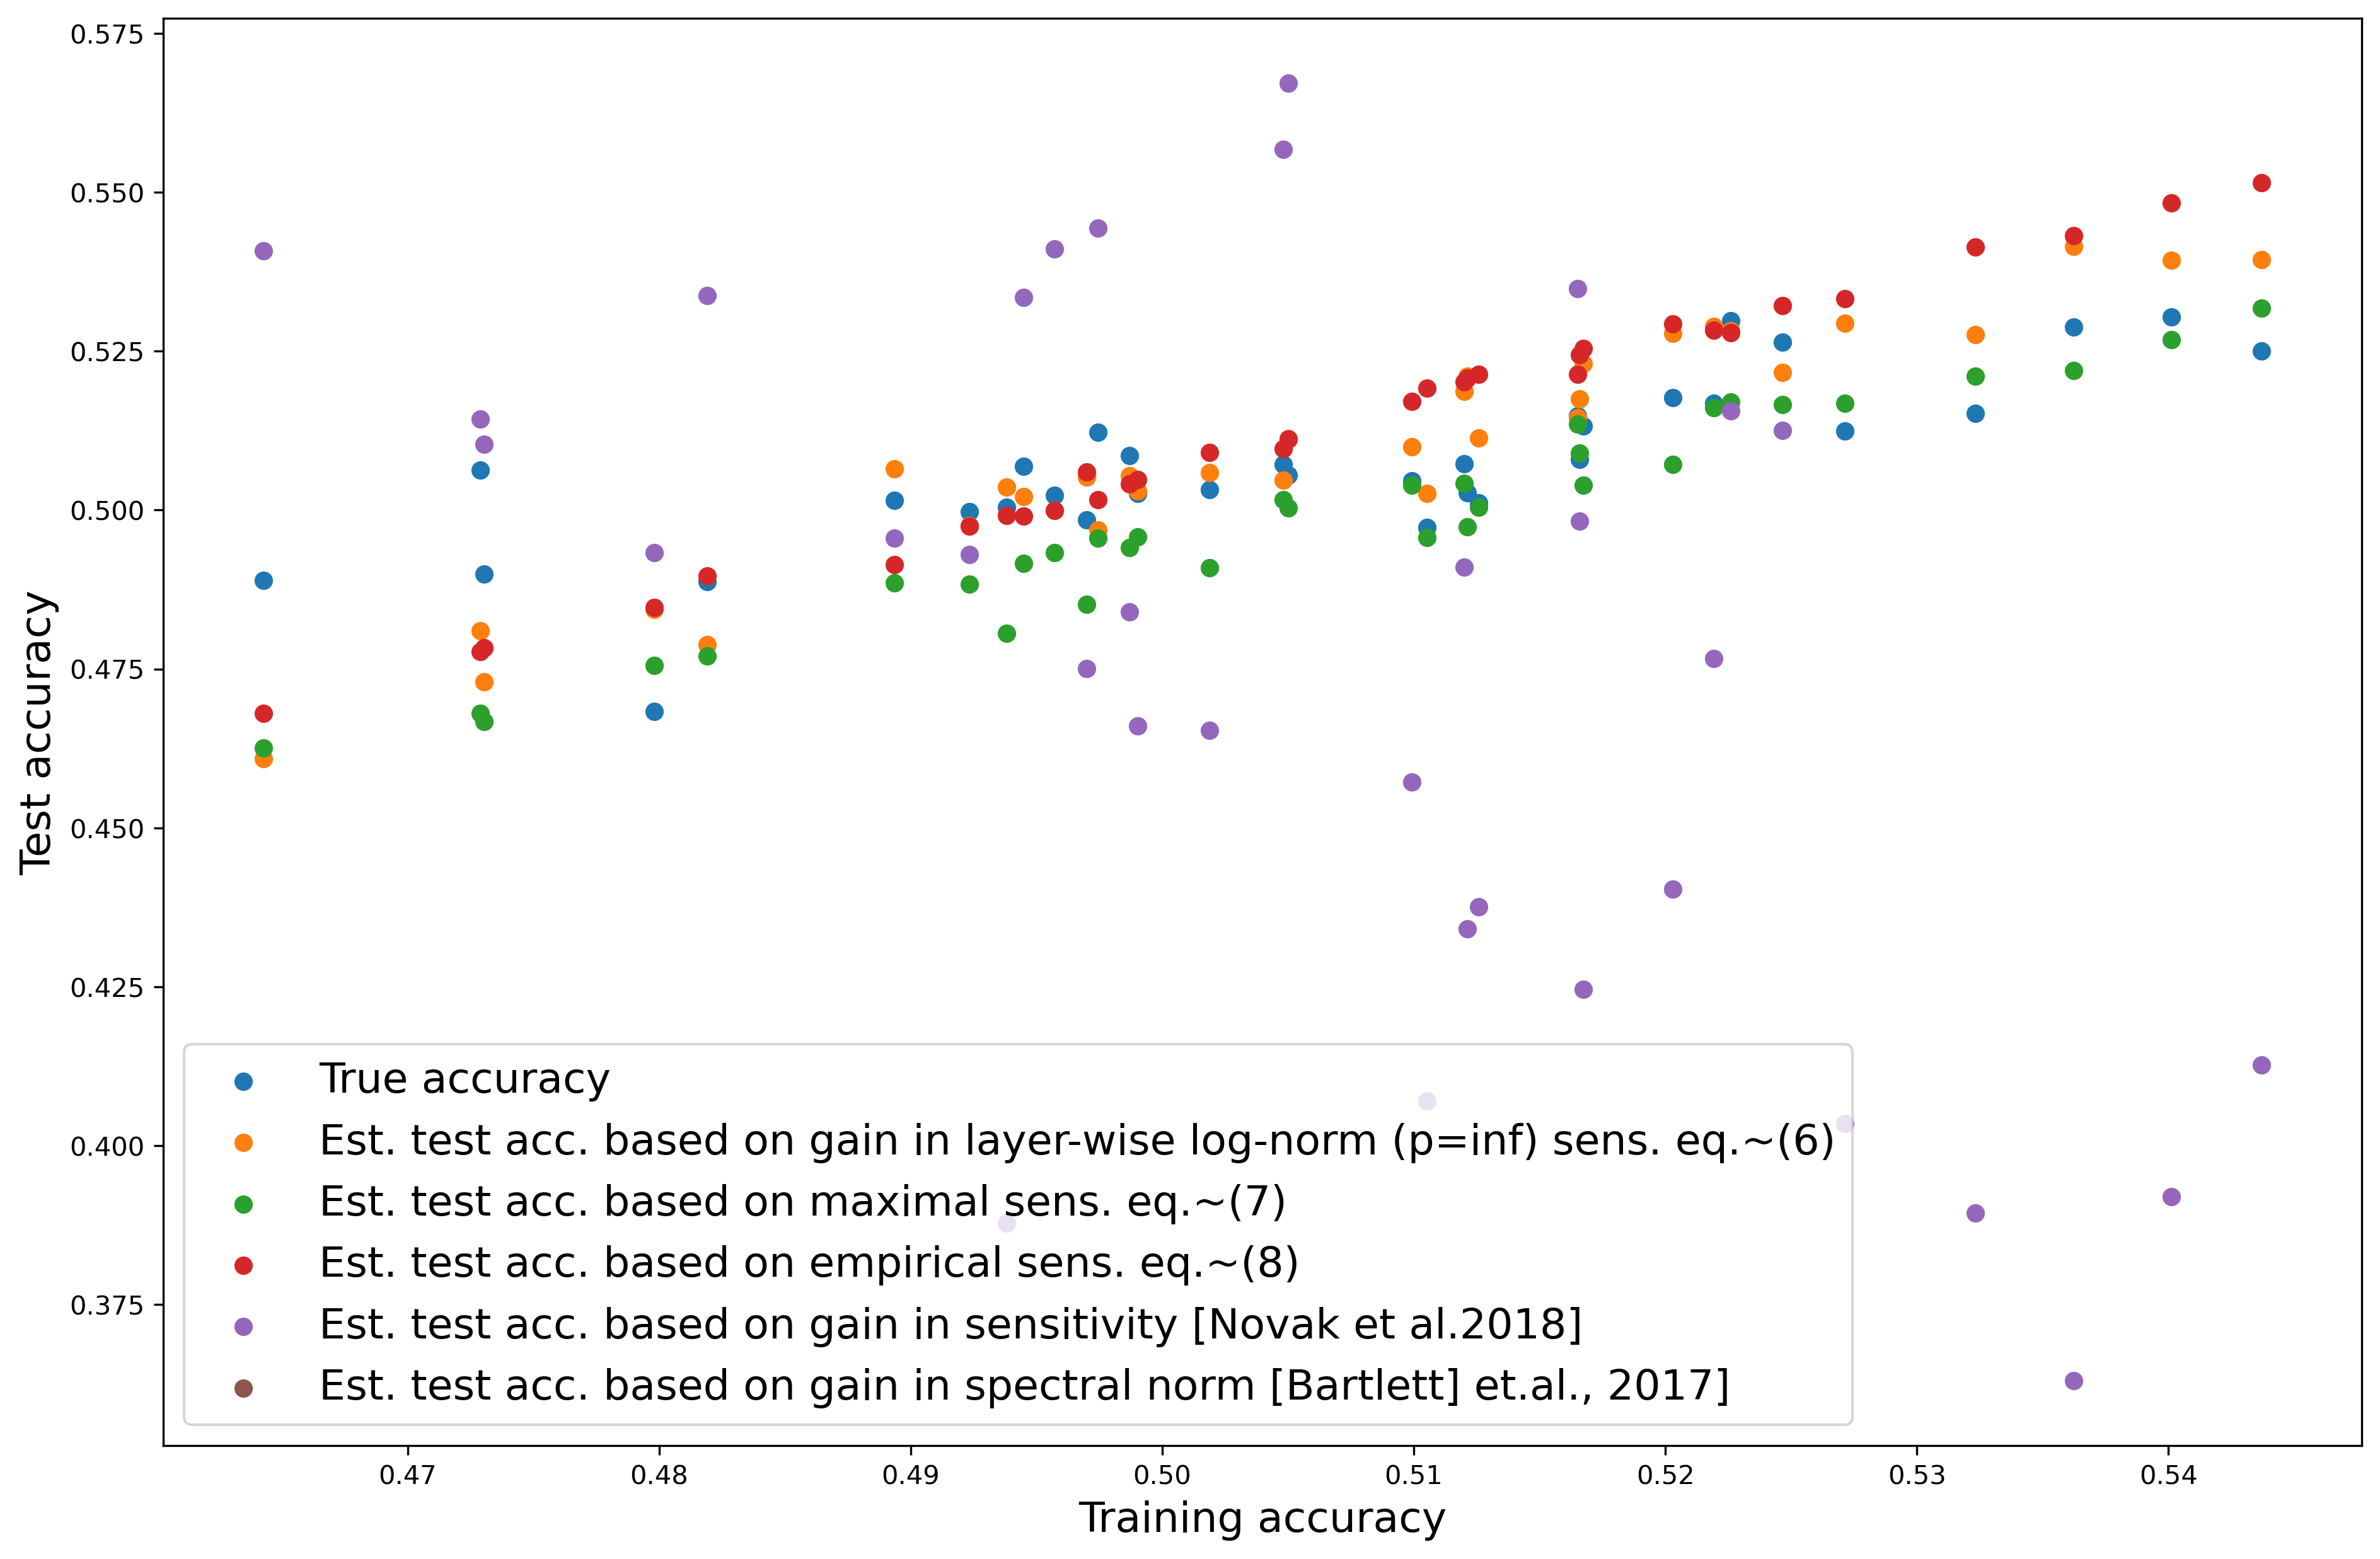

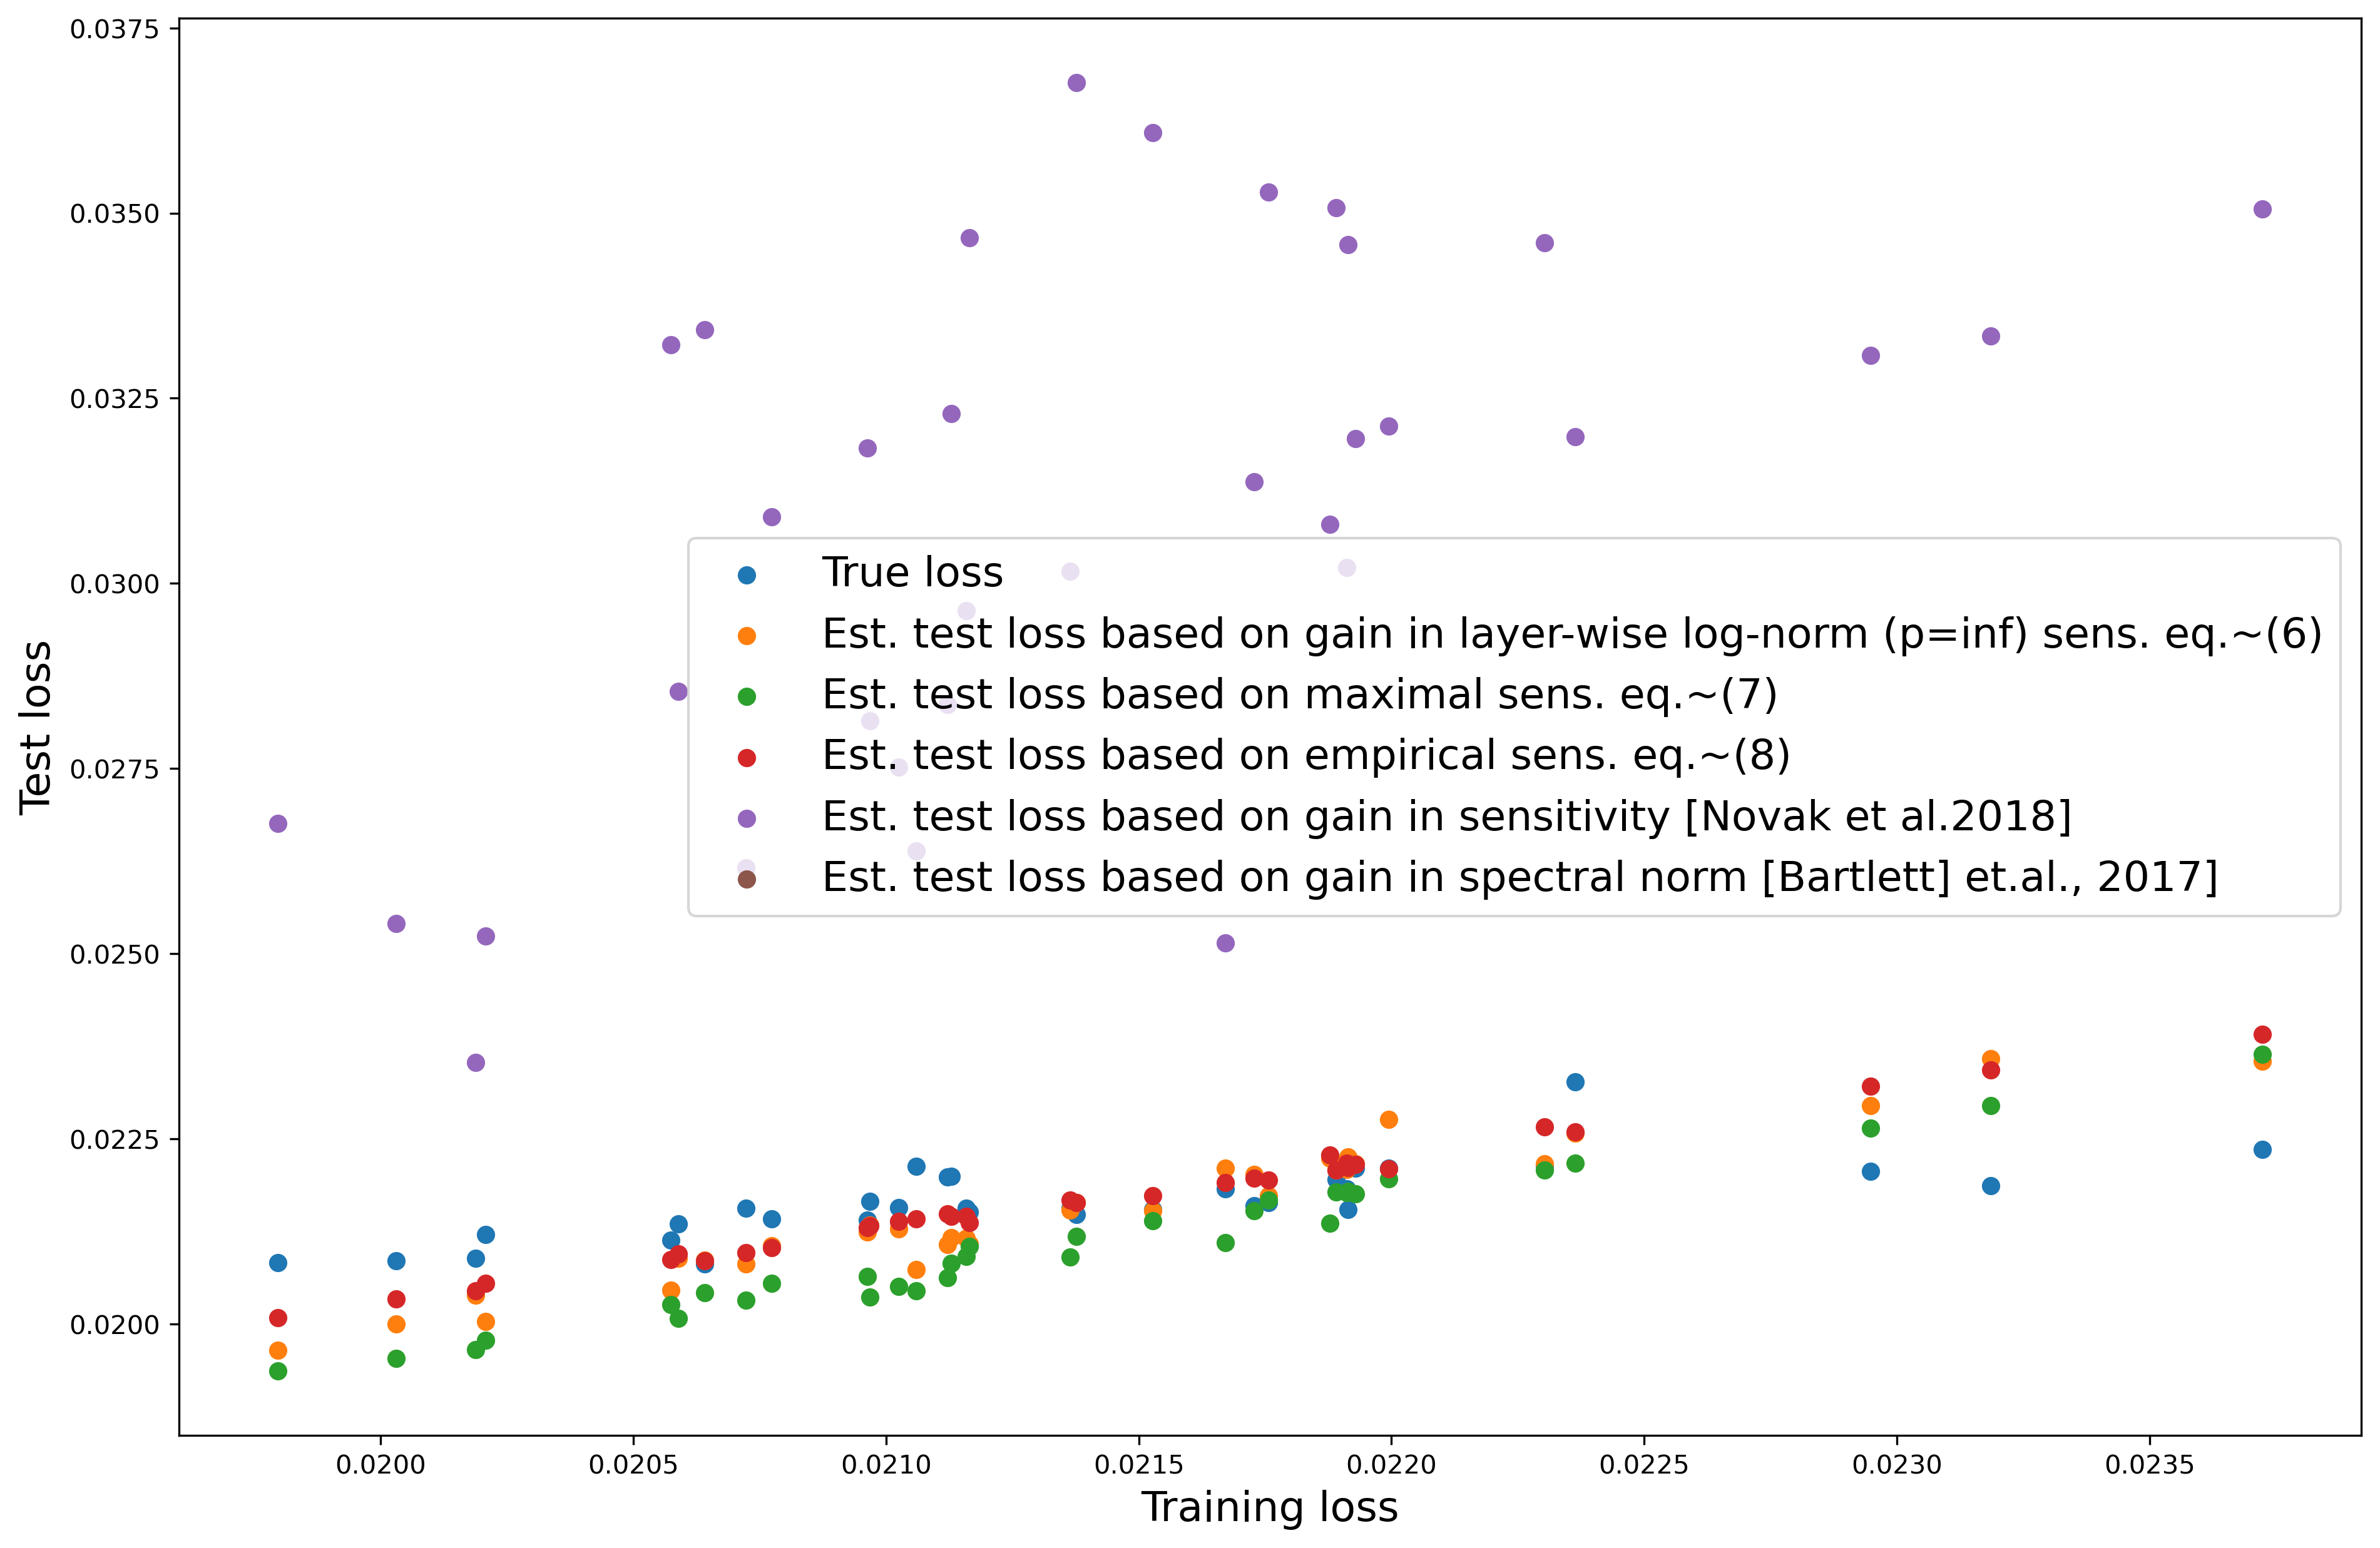

In [20]:
plt.figure(figsize=(15,10),dpi=300)
plt.scatter(acc_tr[15:],acc_te[15:],label="True accuracy")
plt.scatter(acc_tr[15:],acc_tr[15:]*diff_lnorm[15:],label="Est. test acc. based on gain in layer-wise log-norm (p=inf) sens. eq.~(6)")
plt.scatter(acc_tr[15:],acc_tr[15:]*sens_te_max[15:]/sens_tr_max[15:],label="Est. test acc. based on maximal sens. eq.~(7)")
plt.scatter(acc_tr[15:],acc_tr[15:]*m_pr_te[15:]/m_pr_tr[15:],label="Est. test acc. based on empirical sens. eq.~(8)")
#plt.scatter(acc_tr,acc_tr*fd_diff,label="Est. test acc. based on Fisher distance eq.~(7)")

plt.scatter(acc_tr[15:],diff_novak_te_acc[15:],label="Est. test acc. based on gain in sensitivity [Novak et al.2018]")
plt.scatter(acc_tr[15:],diff_spect_te_acc[15:],label="Est. test acc. based on gain in spectral norm [Bartlett] et.al., 2017]")
#plt.scatter(acc_tr[15:],diff_fr_te_acc[15:],label="Est. test acc. based on gain in Fisher-Rao norm [Liang et.al., 2017]")

plt.legend(fontsize=16)
plt.ylabel("Test accuracy",fontsize=16)
plt.xlabel("Training accuracy",fontsize=16)
plt.show()

plt.figure(figsize=(15,10),dpi=300)
plt.scatter(loss_tr[15:],loss_te[15:],label="True loss")
plt.scatter(loss_tr[15:],loss_tr[15:]*diff_lnorm[15:],label="Est. test loss based on gain in layer-wise log-norm (p=inf) sens. eq.~(6)")
plt.scatter(loss_tr[15:],loss_tr[15:]*sens_te_max[15:]/sens_tr_max[15:],label="Est. test loss based on maximal sens. eq.~(7)")
#plt.scatter(acc_tr,acc_tr*sens_te_mean/sens_tr_mean,label="Sens. eq.~(2) mean")
plt.scatter(loss_tr[15:],loss_tr[15:]*m_pr_te[15:]/m_pr_tr[15:],label="Est. test loss based on empirical sens. eq.~(8)")
#plt.scatter(acc_tr,acc_tr*fd_diff,label="Est. test acc. based on Fisher distance eq.~(7)")

#plt.scatter(loss_tr[15:],loss_tr[15:]*diff_novak[15:],label="Est. test loss based on Novak et al. [2018]")

plt.scatter(loss_tr[15:],diff_novak_te_loss[15:],label="Est. test loss based on gain in sensitivity [Novak et al.2018]")
plt.scatter(loss_tr[15:],diff_spect_te_loss[15:],label="Est. test loss based on gain in spectral norm [Bartlett] et.al., 2017]")
#plt.scatter(loss_tr[15:],diff_fr_te_loss[15:],label="Est. test loss based on gain in Fisher-Rao norm [Liang et.al., 2017]")

plt.legend(fontsize=16)
plt.ylabel("Test loss",fontsize=16)
plt.xlabel("Training loss",fontsize=16)
plt.show()